# ViT Implementation with Old LC on MNIST

In [1]:
import glob
import sys
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
import src.compression.deltaCompress as lc_compress
from src.models.ViT import ViT
from src.models.ViTS_MSA_LowRank import getBase, ViTS_MSA_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, evaluate_accuracy_gpu, lazy_restore,lazy_restore_gpu, evaluate_compression
import torchvision

c:\Users\Bradf\anaconda3\envs\py310\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
BATCH_SIZE = 32
LR=0.0002
NUM_EPOCHES = 1000

## Definition of Data Loader function

In [3]:
HDFP = "./volumes/Ultra Touch"  # Placeholder for HDD path

def data_loader():
    # Définir les transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28)),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Charger le dataset d'entraînement MNIST
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # Utiliser les dernières 1000 images pour l'entraînement
    # trainset.data = trainset.data.clone()[-40000:]
    # trainset.targets = trainset.targets.clone()[-40000:]
    trainset.data = trainset.data.clone()[-2000:-1000]
    trainset.targets = trainset.targets.clone()[-2000:-1000]
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    # Charger le dataset de test MNIST
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    # Utiliser les premières 300 images du dataset de test
    testset.data = trainset.data.clone()[-1000:]
    testset.targets = trainset.targets.clone()[-1000:]
    # testset.data = trainset.data.clone()[:3000]
    # testset.targets = trainset.targets.clone()[:3000]
    test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
    
    return train_loader, test_loader


## Calling MNIST dataset

In [4]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

## Bypass the matplotlib error

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Showing some images of the dataset we use

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


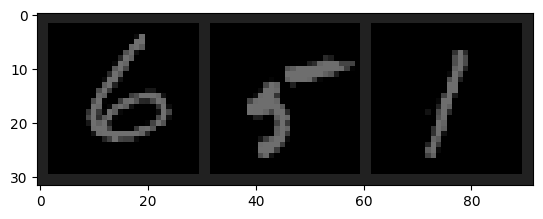

tensor(6) tensor(5) tensor(1)


In [6]:
# Adjust these values to match the normalization values used during the loading of your dataset
mean = 0.1307
std = 0.3081

# Function to show an image
def imshow(img):
    # Adjusting unnormalization for potentially 3-channel images
    img = img * std + mean  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Assuming train_loader is defined and loaded as before
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:3]))
# Print labels
print(' '.join('%5s' % labels[j] for j in range(3)))


## Creation of folder to save the results (for plots and compression rate)

In [7]:
SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

## Definition of the accuracy functions

In [8]:
def accuracy_binary(model, evaluation_set):
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for input, label in evaluation_set:  # Iterate over the evaluation dataset.
            output = torch.sigmoid(model(input))  # Apply sigmoid to model output to get probabilities.
            output = torch.where(output > 0.5, 1, 0)  # Threshold probabilities at 0.5 to decide between classes 0 and 1.
            no_seen += label.size(0)  # Count the number of samples seen (batch size).
            no_correct += (output == label).sum().item()  # Increment correct predictions by the number of matches in the batch.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.

def accuracy_multiclass(model, evaluation_set):
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for input, label in evaluation_set:  # Iterate over the evaluation dataset.
            output = model(input)  # Get the raw logits from the model.
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max logit which represents the predicted class.
            no_seen += label.size(0)  # Count the number of samples seen (batch size).
            no_correct += pred.eq(label.view_as(pred)).sum().item()  # Compare predictions with true labels and sum up correct predictions.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.


## Special function for the accuracy of the model on GPU 

In [9]:
def accuracy_multiclass_gpu(model, evaluation_set):
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Switches the model to evaluation mode.

    no_correct, no_seen = 0, 0  # Initialize counters for correct predictions and total samples seen.

    with torch.no_grad():  # Disables gradient calculation.
        for inputs, labels in evaluation_set:  # Iterate over the evaluation dataset.
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device of the model
            output = model(inputs)  # Get the raw logits from the model.
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max logit which represents the predicted class.
            no_seen += labels.size(0)  # Count the number of samples seen (batch size).
            no_correct += pred.eq(labels.view_as(pred)).sum().item()  # Compare predictions with true labels and sum up correct predictions.
    
    acc = no_correct / no_seen  # Calculate accuracy as the ratio of correct predictions to total samples.
    model.train()  # Switch the model back to training mode.
    return acc  # Return the computed accuracy.


## Usual training on GPU (Creating branchpoints)

In [11]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# get the base model (VGG16NoLite) and move it to the chosen device
# model_for_checkpoint = ViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
model_for_checkpoint = ViT((1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10).to(device)

# creating branchpoints
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=0.0004, momentum=0.9)  # momentum=0.9

for epoch in range(NUM_EPOCHES):
    train_loss = 0.0
    valid_loss = 0.0
    
    model_for_checkpoint.train()
    for iter, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

        optimizer.zero_grad()
        outputs = model_for_checkpoint(inputs)

        # Here assuming your loss function and any other operation are compatible with CUDA tensors
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        if iter % 20 == 0:
            # print("Running validation for {} Epoch, {} Iteration...".format(epoch, iter))
            res = accuracy_multiclass_gpu(model_for_checkpoint, test_loader)  # Ensure this function also handles data on GPU

            # print("ACCURACY: {}".format(res))
            if res > 0.7:
                # Move model to CPU before saving
                model_for_checkpoint.to('cpu')
                torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vitS/branch_{}.pt".format(res))
                # Optionally, move model back to the original device (GPU) if further computation is needed
                print("model saved at accuracy: ", res)
                model_for_checkpoint.to(device)
            if res > 0.9:
                isLoop = False
                break

    # Validation phase
    model_for_checkpoint.eval()
    with torch.no_grad():  # Gradient computation is not needed for validation
        for data, target in test_loader:
            # Move data and target to the correct device
            data, target = data.to(device), target.to(device)

            output = model_for_checkpoint(data)
            loss = torch.nn.CrossEntropyLoss()(output, target)
            valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(test_loader.dataset)

    print("Epoch : [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss))
    if not isLoop:
        break
print("Max epoch reached")


Using device:  cuda:0 (NVIDIA GeForce RTX 4060 Laptop GPU)
Epoch : [0/999], Training Loss: 2.308612, Validation Loss: 2.300126
Epoch : [1/999], Training Loss: 2.308866, Validation Loss: 2.302166
Epoch : [2/999], Training Loss: 2.301739, Validation Loss: 2.290457
Epoch : [3/999], Training Loss: 2.289952, Validation Loss: 2.273528
Epoch : [4/999], Training Loss: 2.265100, Validation Loss: 2.256996
Epoch : [5/999], Training Loss: 2.256778, Validation Loss: 2.250339
Epoch : [6/999], Training Loss: 2.247834, Validation Loss: 2.241429
Epoch : [7/999], Training Loss: 2.232489, Validation Loss: 2.219324
Epoch : [8/999], Training Loss: 2.220486, Validation Loss: 2.207971
Epoch : [9/999], Training Loss: 2.211632, Validation Loss: 2.202067
Epoch : [10/999], Training Loss: 2.205711, Validation Loss: 2.200200
Epoch : [11/999], Training Loss: 2.207266, Validation Loss: 2.192911
Epoch : [12/999], Training Loss: 2.198009, Validation Loss: 2.200446
Epoch : [13/999], Training Loss: 2.200977, Validation 

## Exploiting branchpoints of the model

In [10]:
# DECOMPOSED_LAYERS = ['classifier.0.weight', 'classifier.4.weight', 'classifier.8.weight'
DECOMPOSED_LAYERS = [
        'blocks.0.mhsa.q_mappings.0.weight',  'blocks.0.mhsa.q_mappings.1.weight',
         'blocks.0.mhsa.q_mappings.2.weight',  'blocks.0.mhsa.q_mappings.3.weight',
         'blocks.0.mhsa.q_mappings.4.weight',  'blocks.0.mhsa.q_mappings.5.weight',
         'blocks.0.mhsa.q_mappings.6.weight',  'blocks.0.mhsa.q_mappings.7.weight',

         'blocks.0.mhsa.k_mappings.0.weight',  'blocks.0.mhsa.k_mappings.1.weight',
         'blocks.0.mhsa.k_mappings.2.weight',  'blocks.0.mhsa.k_mappings.3.weight',
         'blocks.0.mhsa.k_mappings.4.weight',  'blocks.0.mhsa.k_mappings.5.weight',
         'blocks.0.mhsa.k_mappings.6.weight',  'blocks.0.mhsa.k_mappings.7.weight',

         'blocks.0.mhsa.v_mappings.0.weight',  'blocks.0.mhsa.v_mappings.1.weight',
         'blocks.0.mhsa.v_mappings.2.weight',  'blocks.0.mhsa.v_mappings.3.weight',
         'blocks.0.mhsa.v_mappings.4.weight',  'blocks.0.mhsa.v_mappings.5.weight',
         'blocks.0.mhsa.v_mappings.6.weight',  'blocks.0.mhsa.v_mappings.7.weight',






         'blocks.1.mhsa.q_mappings.0.weight',  'blocks.1.mhsa.q_mappings.1.weight',
         'blocks.1.mhsa.q_mappings.2.weight',  'blocks.1.mhsa.q_mappings.3.weight',
         'blocks.1.mhsa.q_mappings.4.weight',  'blocks.1.mhsa.q_mappings.5.weight',
         'blocks.1.mhsa.q_mappings.6.weight',  'blocks.1.mhsa.q_mappings.7.weight',

         'blocks.1.mhsa.k_mappings.0.weight',  'blocks.1.mhsa.k_mappings.1.weight',
         'blocks.1.mhsa.k_mappings.2.weight',  'blocks.1.mhsa.k_mappings.3.weight',
         'blocks.1.mhsa.k_mappings.4.weight',  'blocks.1.mhsa.k_mappings.5.weight',
         'blocks.1.mhsa.k_mappings.6.weight',  'blocks.1.mhsa.k_mappings.7.weight',

         'blocks.1.mhsa.v_mappings.0.weight',  'blocks.1.mhsa.v_mappings.1.weight',
         'blocks.1.mhsa.v_mappings.2.weight',  'blocks.1.mhsa.v_mappings.3.weight',
         'blocks.1.mhsa.v_mappings.4.weight',  'blocks.1.mhsa.v_mappings.5.weight',
         'blocks.1.mhsa.v_mappings.6.weight',  'blocks.1.mhsa.v_mappings.7.weight',






         'blocks.2.mhsa.q_mappings.0.weight',  'blocks.2.mhsa.q_mappings.1.weight',
         'blocks.2.mhsa.q_mappings.2.weight',  'blocks.2.mhsa.q_mappings.3.weight',
         'blocks.2.mhsa.q_mappings.4.weight',  'blocks.2.mhsa.q_mappings.5.weight',
         'blocks.2.mhsa.q_mappings.6.weight',  'blocks.2.mhsa.q_mappings.7.weight',

         'blocks.2.mhsa.k_mappings.0.weight',  'blocks.2.mhsa.k_mappings.1.weight',
         'blocks.2.mhsa.k_mappings.2.weight',  'blocks.2.mhsa.k_mappings.3.weight',
         'blocks.2.mhsa.k_mappings.4.weight',  'blocks.2.mhsa.k_mappings.5.weight',
         'blocks.2.mhsa.k_mappings.6.weight',  'blocks.2.mhsa.k_mappings.7.weight',

         'blocks.2.mhsa.v_mappings.0.weight',  'blocks.2.mhsa.v_mappings.1.weight',
         'blocks.2.mhsa.v_mappings.2.weight',  'blocks.2.mhsa.v_mappings.3.weight',
         'blocks.2.mhsa.v_mappings.4.weight',  'blocks.2.mhsa.v_mappings.5.weight',
         'blocks.2.mhsa.v_mappings.6.weight',  'blocks.2.mhsa.v_mappings.7.weight',






         'blocks.3.mhsa.q_mappings.0.weight',  'blocks.3.mhsa.q_mappings.1.weight',
         'blocks.3.mhsa.q_mappings.2.weight',  'blocks.3.mhsa.q_mappings.3.weight',
         'blocks.3.mhsa.q_mappings.4.weight',  'blocks.3.mhsa.q_mappings.5.weight',
         'blocks.3.mhsa.q_mappings.6.weight',  'blocks.3.mhsa.q_mappings.7.weight',

         'blocks.3.mhsa.k_mappings.0.weight',  'blocks.3.mhsa.k_mappings.1.weight',
         'blocks.3.mhsa.k_mappings.2.weight',  'blocks.3.mhsa.k_mappings.3.weight',
         'blocks.3.mhsa.k_mappings.4.weight',  'blocks.3.mhsa.k_mappings.5.weight',
         'blocks.3.mhsa.k_mappings.6.weight',  'blocks.3.mhsa.k_mappings.7.weight',

         'blocks.3.mhsa.v_mappings.0.weight',  'blocks.3.mhsa.v_mappings.1.weight',
         'blocks.3.mhsa.v_mappings.2.weight',  'blocks.3.mhsa.v_mappings.3.weight',
         'blocks.3.mhsa.v_mappings.4.weight',  'blocks.3.mhsa.v_mappings.5.weight',
         'blocks.3.mhsa.v_mappings.6.weight',  'blocks.3.mhsa.v_mappings.7.weight',






         'blocks.4.mhsa.q_mappings.0.weight',  'blocks.4.mhsa.q_mappings.1.weight',
         'blocks.4.mhsa.q_mappings.2.weight',  'blocks.4.mhsa.q_mappings.3.weight',
         'blocks.4.mhsa.q_mappings.4.weight',  'blocks.4.mhsa.q_mappings.5.weight',
         'blocks.4.mhsa.q_mappings.6.weight',  'blocks.4.mhsa.q_mappings.7.weight',

         'blocks.4.mhsa.k_mappings.0.weight',  'blocks.4.mhsa.k_mappings.1.weight',
         'blocks.4.mhsa.k_mappings.2.weight',  'blocks.4.mhsa.k_mappings.3.weight',
         'blocks.4.mhsa.k_mappings.4.weight',  'blocks.4.mhsa.k_mappings.5.weight',
         'blocks.4.mhsa.k_mappings.6.weight',  'blocks.4.mhsa.k_mappings.7.weight',

         'blocks.4.mhsa.v_mappings.0.weight',  'blocks.4.mhsa.v_mappings.1.weight',
         'blocks.4.mhsa.v_mappings.2.weight',  'blocks.4.mhsa.v_mappings.3.weight',
         'blocks.4.mhsa.v_mappings.4.weight',  'blocks.4.mhsa.v_mappings.5.weight',
         'blocks.4.mhsa.v_mappings.6.weight',  'blocks.4.mhsa.v_mappings.7.weight',






         'blocks.5.mhsa.q_mappings.0.weight',  'blocks.5.mhsa.q_mappings.1.weight',
         'blocks.5.mhsa.q_mappings.2.weight',  'blocks.5.mhsa.q_mappings.3.weight',
         'blocks.5.mhsa.q_mappings.4.weight',  'blocks.5.mhsa.q_mappings.5.weight',
         'blocks.5.mhsa.q_mappings.6.weight',  'blocks.5.mhsa.q_mappings.7.weight',

         'blocks.5.mhsa.k_mappings.0.weight',  'blocks.5.mhsa.k_mappings.1.weight',
         'blocks.5.mhsa.k_mappings.2.weight',  'blocks.5.mhsa.k_mappings.3.weight',
         'blocks.5.mhsa.k_mappings.4.weight',  'blocks.5.mhsa.k_mappings.5.weight',
         'blocks.5.mhsa.k_mappings.6.weight',  'blocks.5.mhsa.k_mappings.7.weight',

         'blocks.5.mhsa.v_mappings.0.weight',  'blocks.5.mhsa.v_mappings.1.weight',
         'blocks.5.mhsa.v_mappings.2.weight',  'blocks.5.mhsa.v_mappings.3.weight',
         'blocks.5.mhsa.v_mappings.4.weight',  'blocks.5.mhsa.v_mappings.5.weight',
         'blocks.5.mhsa.v_mappings.6.weight',  'blocks.5.mhsa.v_mappings.7.weight',






         'blocks.6.mhsa.q_mappings.0.weight',  'blocks.6.mhsa.q_mappings.1.weight',
         'blocks.6.mhsa.q_mappings.2.weight',  'blocks.6.mhsa.q_mappings.3.weight',
         'blocks.6.mhsa.q_mappings.4.weight',  'blocks.6.mhsa.q_mappings.5.weight',
         'blocks.6.mhsa.q_mappings.6.weight',  'blocks.6.mhsa.q_mappings.7.weight',

         'blocks.6.mhsa.k_mappings.0.weight',  'blocks.6.mhsa.k_mappings.1.weight',
         'blocks.6.mhsa.k_mappings.2.weight',  'blocks.6.mhsa.k_mappings.3.weight',
         'blocks.6.mhsa.k_mappings.4.weight',  'blocks.6.mhsa.k_mappings.5.weight',
         'blocks.6.mhsa.k_mappings.6.weight',  'blocks.6.mhsa.k_mappings.7.weight',

         'blocks.6.mhsa.v_mappings.0.weight',  'blocks.6.mhsa.v_mappings.1.weight',
         'blocks.6.mhsa.v_mappings.2.weight',  'blocks.6.mhsa.v_mappings.3.weight',
         'blocks.6.mhsa.v_mappings.4.weight',  'blocks.6.mhsa.v_mappings.5.weight',
         'blocks.6.mhsa.v_mappings.6.weight',  'blocks.6.mhsa.v_mappings.7.weight',


    ]
RANK = -1
SCALING = -1
BRANCH_ACC = "0.879"

# CUDA setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model setup
original =  ViT((1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10).to(device)
model_original =  ViT((1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10).to(device)

# Load state from a checkpoint into the GPU directly
BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/vitS/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))


Using device: cuda:0


<All keys matched successfully>

In [11]:
print(model_original.state_dict().keys())

odict_keys(['class_token', 'linear_mapper.weight', 'linear_mapper.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.mhsa.q_mappings.0.weight', 'blocks.0.mhsa.q_mappings.0.bias', 'blocks.0.mhsa.q_mappings.1.weight', 'blocks.0.mhsa.q_mappings.1.bias', 'blocks.0.mhsa.q_mappings.2.weight', 'blocks.0.mhsa.q_mappings.2.bias', 'blocks.0.mhsa.q_mappings.3.weight', 'blocks.0.mhsa.q_mappings.3.bias', 'blocks.0.mhsa.q_mappings.4.weight', 'blocks.0.mhsa.q_mappings.4.bias', 'blocks.0.mhsa.q_mappings.5.weight', 'blocks.0.mhsa.q_mappings.5.bias', 'blocks.0.mhsa.q_mappings.6.weight', 'blocks.0.mhsa.q_mappings.6.bias', 'blocks.0.mhsa.q_mappings.7.weight', 'blocks.0.mhsa.q_mappings.7.bias', 'blocks.0.mhsa.k_mappings.0.weight', 'blocks.0.mhsa.k_mappings.0.bias', 'blocks.0.mhsa.k_mappings.1.weight', 'blocks.0.mhsa.k_mappings.1.bias', 'blocks.0.mhsa.k_mappings.2.weight', 'blocks.0.mhsa.k_mappings.2.bias', 'blocks.0.mhsa.k_mappings.3.weight', 'blocks.0.mhsa.k_mappings.3.bias', 'blocks.0.mhsa.

In [12]:
w, b = getBase(model_original)

In [13]:
w

[tensor([[-0.0023, -0.0146, -0.0163,  ...,  0.1013,  0.0769,  0.0267],
         [ 0.0247,  0.1231,  0.0782,  ..., -0.0570,  0.0177,  0.0170],
         [ 0.0700,  0.0912, -0.0995,  ..., -0.0684, -0.0161,  0.0266],
         ...,
         [-0.1018, -0.0625, -0.0134,  ..., -0.1136, -0.1186,  0.0560],
         [-0.0645, -0.1099,  0.0692,  ...,  0.0732,  0.1174, -0.0889],
         [ 0.1082,  0.1057, -0.0511,  ...,  0.0626,  0.1135,  0.0233]],
        device='cuda:0'),
 tensor([[-1.1883e-01,  1.8452e-02,  7.1516e-02,  ...,  4.7337e-02,
           2.8415e-02,  1.0106e-01],
         [-5.5686e-02, -8.1730e-02,  7.3673e-02,  ..., -1.0128e-01,
           1.0847e-01, -1.2321e-01],
         [-5.1252e-02,  1.7183e-02,  1.2380e-01,  ...,  5.4581e-04,
          -1.0457e-01,  9.2886e-02],
         ...,
         [ 7.3467e-02, -4.1369e-02, -1.2009e-01,  ...,  3.1768e-02,
          -2.7438e-04,  6.0171e-02],
         [-3.5405e-02,  7.9196e-03, -8.0665e-05,  ...,  1.0943e-01,
           1.6662e-02,  1.0958e

In [14]:
b

[tensor([ 0.0386, -0.0792,  0.1009, -0.0159,  0.1214,  0.0793,  0.1194, -0.0307,
         -0.0972,  0.1185,  0.0126,  0.0814, -0.0493, -0.0587, -0.1017, -0.1085,
         -0.1190, -0.0011, -0.0407,  0.0977, -0.0347,  0.0697, -0.0090, -0.0658,
         -0.0900, -0.0026,  0.0679,  0.0673, -0.0944, -0.1005,  0.0027, -0.0590,
         -0.1099,  0.0175,  0.0300,  0.0435, -0.0792,  0.1143, -0.1065, -0.0656,
         -0.0511,  0.0877, -0.0720,  0.1166, -0.0792,  0.1130,  0.0481,  0.1244,
         -0.0421,  0.1001, -0.0304,  0.0928, -0.0863, -0.0036, -0.0715,  0.0336,
         -0.0191, -0.0158,  0.0206, -0.0480,  0.0074, -0.0432,  0.0653, -0.0714],
        device='cuda:0'),
 tensor([-0.1237,  0.0761,  0.0385, -0.1072, -0.0332,  0.0683, -0.0435, -0.0507,
         -0.0075, -0.0942,  0.0538,  0.1158, -0.1095, -0.0263,  0.0348, -0.0767,
         -0.0151, -0.0372, -0.0060, -0.0775,  0.0949,  0.0858, -0.0761, -0.0225,
          0.0973,  0.0118, -0.0961, -0.0508, -0.1088, -0.0549, -0.0780,  0.0380,
 

In [15]:
model = ViTS_MSA_LowRank(w, b , RANK, (1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10).to(device)

In [16]:
# Load decomposed layers
load_sd_decomp(torch.load(BRANCH_LOC, map_location=device), model, DECOMPOSED_LAYERS)

# Optimizers for both models
learning_rate = 0.0004
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer_full = torch.optim.SGD(model_original.parameters(), lr=learning_rate, momentum=0.9)

### Training using checkpoint, creation of model with only LC-checkpoint and another with LC-checkpoint + LoRA

In [18]:
# Initialize lists to store the maximum and minimum values of the delta and decomposed delta
delta_normal_max = []
delta_normal_min = []
delta_decomposed_max = []
delta_decomposed_min = []

# Initialize lists to store the maximum and minimum values of the compressed delta and decomposed delta
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []

# Initialize the current iteration and set to 0
current_iter = 0
current_set = 0

# Initialize the current iteration and set to 0 for the old LC method
current_iter_old_lc = 0
current_set_old_lc = 0

# Define a function to evaluate the accuracy of the model on the test set
acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)

# Train the model for 100 epochs
for epch in range(20):
    # Iterate over the training data
    for i, data in enumerate(train_loader, 0):
        print("Epoch: {}, Iteration: {}".format(epch, i))
        
        # Create a new set directory if it does not exist
        set_path = "/set_{}".format(current_set)
        if not os.path.exists(SAVE_LOC + set_path):
            os.makedirs(SAVE_LOC + set_path)

        # Check if it is the first iteration of the first epoch
        if i == 0 and epch == 0: # first iteration, create baseline model
            base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)
        # Check if it is a full snapshot
        else:
            # Check if the iteration is a multiple of 10
            if i % 10 == 0: 
                # full snapshot!

                new_model = lazy_restore_gpu(base, base_decomp, bias, ViT((1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10), 
                                          original.state_dict(), DECOMPOSED_LAYERS, rank = RANK, scaling = SCALING)
                # Changing previous "original model" used to restore the loRA model.
                original = new_model 
                
                current_set += 1
                current_iter = 0

                # Create a new set directory if it does not exist
                set_path = "/set_{}".format(current_set)
                if not os.path.exists(SAVE_LOC + set_path):
                    os.makedirs(SAVE_LOC + set_path)
                
                # Rebuilding LoRA layers => reset model!

                # Get the base model weights and biases
                w, b = getBase(original)
                # Create a new model with the base weights and specified rank
                model = ViTS_MSA_LowRank(w, b , RANK, (1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10).to(device)
                # Optimizer for the model's parameters with Stochastic Gradient Descent (SGD) and specified learning rate
                optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
                # Load state dictionary from full snapshot, including specified decomposed layers, and load it into the model
                load_sd_decomp(original.state_dict(), model, DECOMPOSED_LAYERS)
                # The base for all delta calculations
                base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)

            # If it is not a full snapshot, perform delta compression
            else:
                # Delta-compression : The delta for the weights of the normal and decomposed layers.
                # Also returns the full dictionary, which holds the bias.
                delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                
                # Compressing the delta and decomposed delta
                compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                            decomp_delta)
                
                # Saving checkpoint
                lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                                "/set_{}".format(current_set))
    
                # Update base and base_decomp
                base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                base_decomp = np.add(full_dcomp_delta, base_decomp)

                # Update current iteration
                current_iter += 1
            
        # # ==========================
        # # Saving using LC-Checkpoint
        # # ==========================
                
        if i == 0 and epch == 0:
            cstate = model_original.state_dict()
            set_path = "/set_{}".format(current_set_old_lc)
            if not os.path.exists(SAVE_LOC_OLC + set_path):
                os.makedirs(SAVE_LOC_OLC + set_path)
            prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
        else:
            if i % 10 == 0:
                cstate = model_original.state_dict()
                current_set_old_lc += 1
                current_iter_old_lc = 0
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path, DECOMPOSED_LAYERS)
            else:
                cstate = model_original.state_dict()
                old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                                    old_lc_bias, current_iter_old_lc)
                prev_state = np.add(prev_state, update_prev)
                current_iter_old_lc += 1
        
        # ==========================
        # Training on Low-Rank Model
        # ==========================

        # Get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs,labels)
        # print("LoRA+LC Training Loss (Decomposed): {}".format(loss.item()))
        loss.backward()
        optimizer.step()
            
        # ======================
        # Training on Full Model
        # ======================

        # Zero the parameter gradients
        optimizer_full.zero_grad()

        # Forward + backward + optimize
        outputs_full = model_original(inputs)
        loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
        # print("LC Training Loss (Full): {}".format(loss_full.item()))
        loss_full.backward()
        optimizer_full.step()

        # Print training accuracy every 20 iterations
        if i % 10 == 0:
            print("Training Accuracy | Decomposed: {}, Full : {}".format(acc(outputs, labels), 
                                                                         acc(outputs_full, labels)))

        # Evaluation every 5 iterations
        if i != 0  and i % 5 == 0: # Evaluation on testing set

            # Evaluate the accuracy of the model on the test set
            full_accuracy.append(evaluate_accuracy_gpu(model_original, test_loader))

            # Evaluate the accuracy of the model on the test set for decomposed model
            decomposed_full_accuracy.append(evaluate_accuracy_gpu(model, test_loader))

            # Restore the model from the full snapshot
            restored_model = lazy_restore_gpu(base, base_decomp, bias, ViT((1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10), 
                                          original.state_dict(), DECOMPOSED_LAYERS, 
                                          rank = RANK, scaling = SCALING)

            # Evaluate the accuracy of the restored model on the test set
            restored_accuracy.append(evaluate_accuracy(restored_model, test_loader))

            # Restore VGG16NoLite model from the old LC method
            restored_lc_model = ViT((1, 28, 28), n_patches=14, n_blocks=7, hidden_d=512, n_heads=8, out_d=10).to(device)
            restored_lc_model.load_state_dict(olc.restore_state_dict(prev_state, old_lc_bias, 
                                                                  restored_model.state_dict(), DECOMPOSED_LAYERS))
            lc_accuracy.append(evaluate_accuracy_gpu(restored_lc_model, test_loader))
            print("Full accuracy: {}, LC accuracy: {}, Decomposed-Full accuracy: {}, Decomposed-Restored accuracy: {}".format(
                full_accuracy[-1], lc_accuracy[-1], decomposed_full_accuracy[-1], restored_accuracy[-1]))

Epoch: 0, Iteration: 0
saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/lobranch/set_0\base_model.pt
old_lc | saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/old-lc/set_0/initial_model.pt
Training Accuracy | Decomposed: 0.875, Full : 0.875
Epoch: 0, Iteration: 1
Saving Checkpoint: lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/lobranch/set_0
Saving Checkpoint: old_lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/old-lc/set_0
Epoch: 0, Iteration: 2
Saving Checkpoint: lc_checkpoint_1.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/lobranch/set_0
Saving Checkpoint: old_lc_checkpoint_1.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/old-lc/set_0
Epoch: 0, Iteration: 3
Saving Checkpoint: lc_checkpoint_2.pt @ ./volumes/Ultra Touch/lobranch-snapshot/di

## For recovery and not restart from scratch : having the plots and the results

In [ ]:
import json

# Open a file to save the data (if it exists, otherwise ignore this cell)
with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vit/data.json") as f:
    data = json.load(f)

# Update the data with the new values
full_accuracy = data['full_acc']
lc_accuracy = data["lc_restored_accuracy"]
restored_accuracy = data["decomposed_restored_accuracy"]
decomposed_full_accuracy = data["decomposed_full_accuracy"]

### Plotting the results

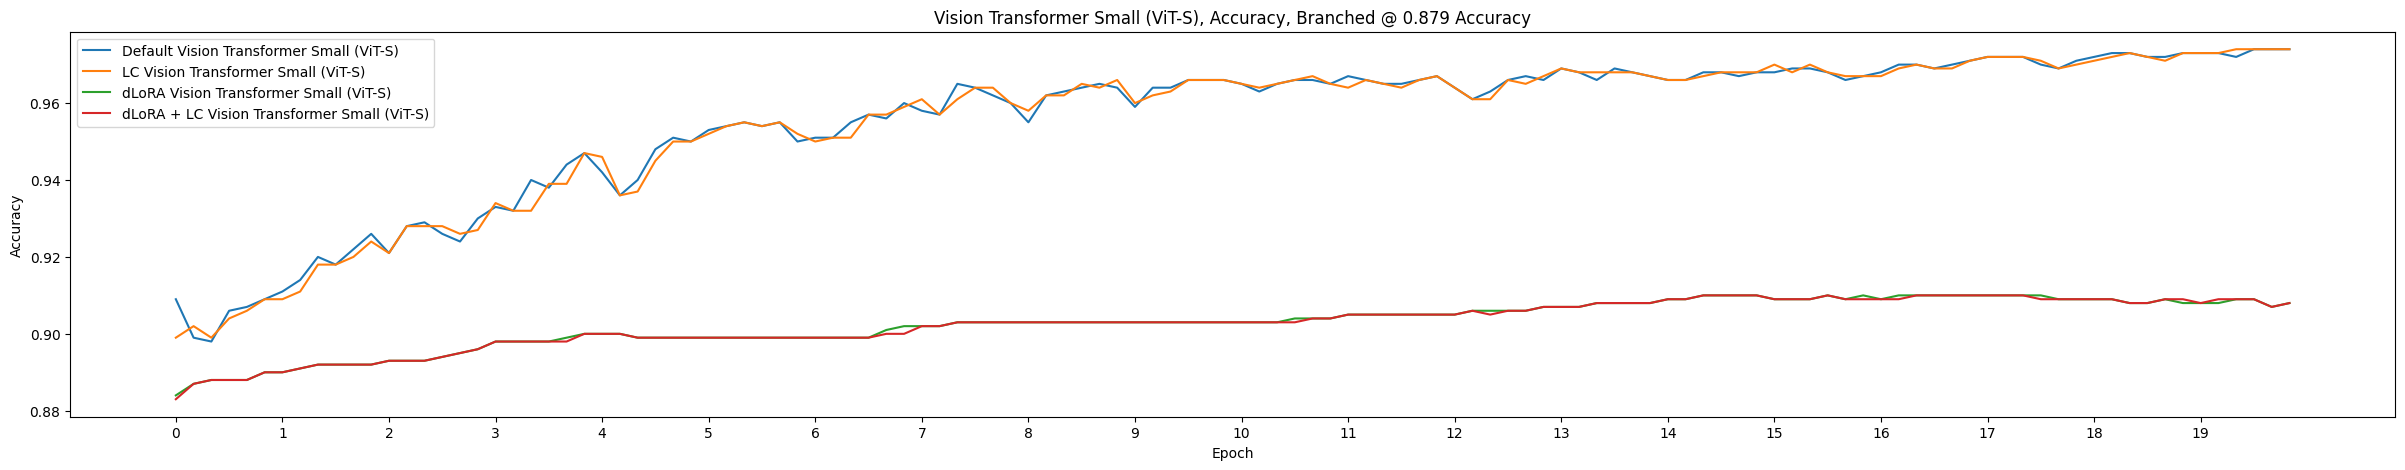

In [19]:
plt.figure(figsize = (30, 5))
plt.title("Vision Transformer Small (ViT-S), Accuracy, Branched @ {} Accuracy".format(BRANCH_ACC))
plt.plot(full_accuracy, label = "Default Vision Transformer Small (ViT-S)")
plt.plot(lc_accuracy, label = "LC Vision Transformer Small (ViT-S)")
plt.plot(decomposed_full_accuracy, label = "dLoRA Vision Transformer Small (ViT-S)")
plt.plot(restored_accuracy, label = "dLoRA + LC Vision Transformer Small (ViT-S)")
plt.xticks([x for x in range(0, 120) if x % 6 == 0], [x for x in range(0, 20)])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Plotting the absolute accuracy loss

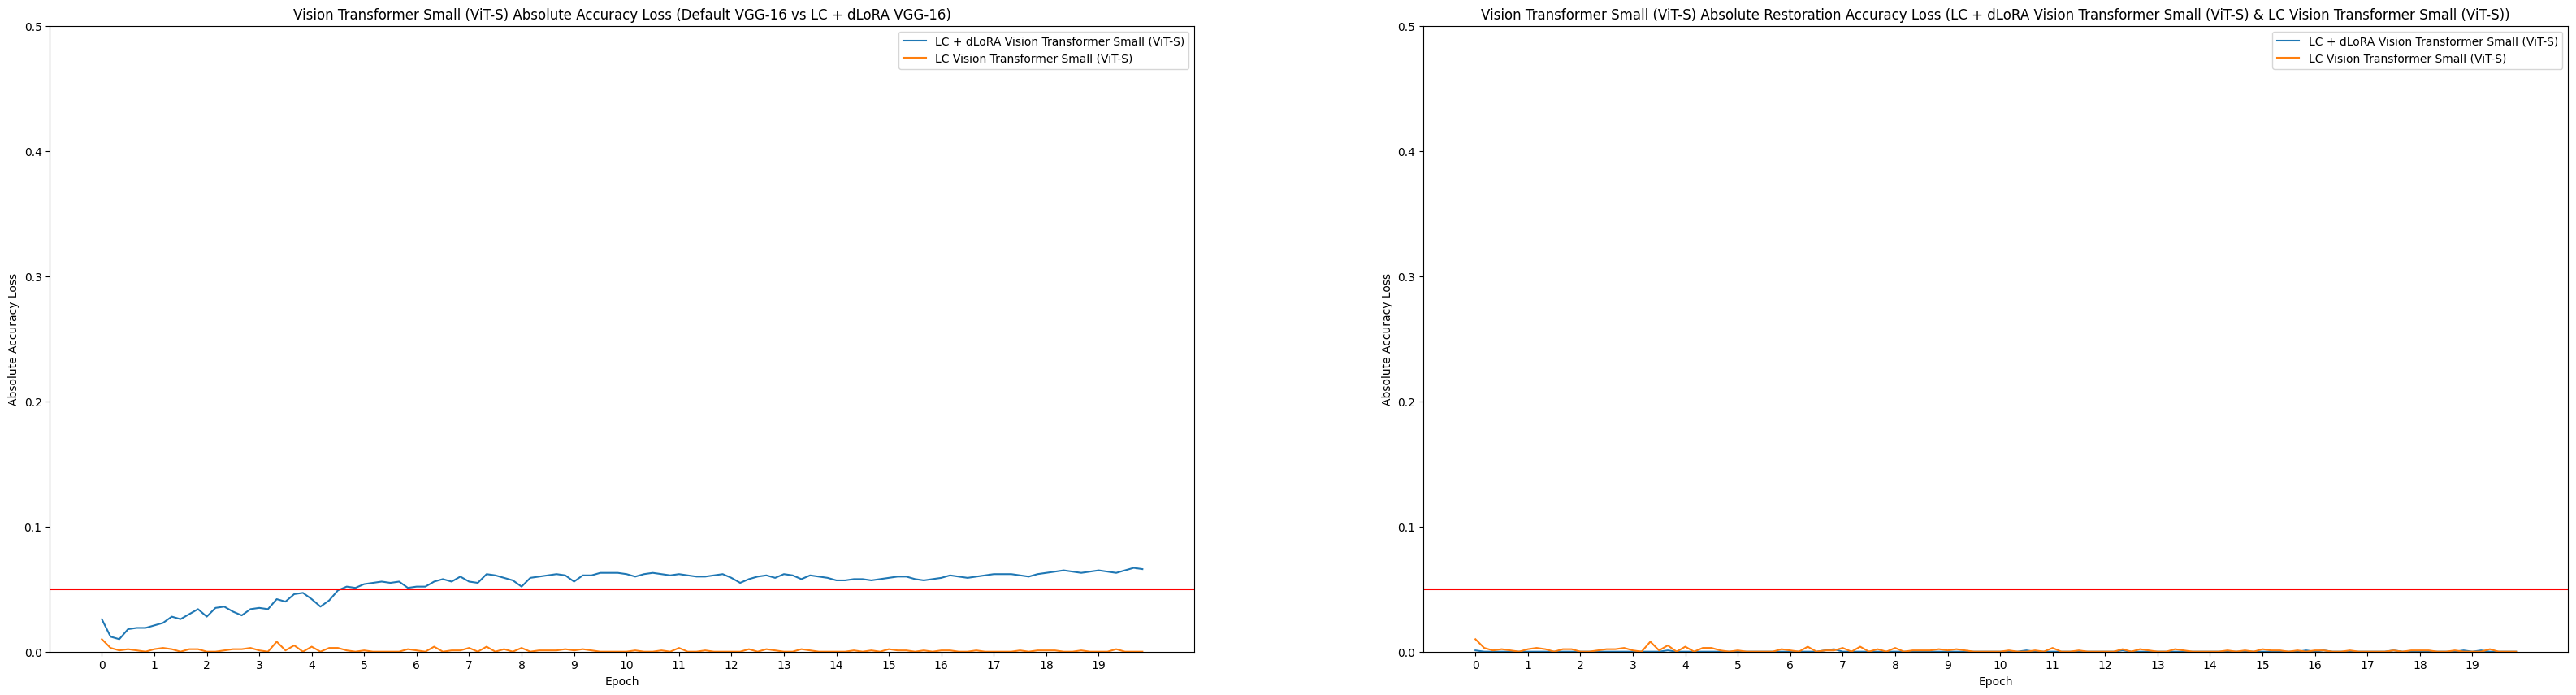

In [20]:
rangex = [x for x in range(0, 120) if x % 6 == 0]
rangey = [x for x in range(0, 20)]
plt.figure(figsize = (40, 10))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("Vision Transformer Small (ViT-S) Absolute Accuracy Loss (Default VGG-16 vs LC + dLoRA VGG-16)")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(restored_accuracy))), label = "LC + dLoRA Vision Transformer Small (ViT-S)")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC Vision Transformer Small (ViT-S)")
plt.legend()
plt.xticks(rangex, rangey)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.axhline(y = 0.05, color = 'r')
plt.ylim(0, 0.5)
ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Vision Transformer Small (ViT-S) Absolute Restoration Accuracy Loss (LC + dLoRA Vision Transformer Small (ViT-S) & LC Vision Transformer Small (ViT-S))")
plt.plot(np.abs(np.subtract(np.array(restored_accuracy), 
                     np.array(decomposed_full_accuracy))), label = "LC + dLoRA Vision Transformer Small (ViT-S)")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC Vision Transformer Small (ViT-S)")
plt.legend()
plt.axhline(y = 0.05, color = 'r')
plt.xticks(rangex, rangey)
plt.ylim(0, 0.5)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.show()

### Function which compute the size of compressed and uncompressed model

In [21]:
import math
def getsize(sl):
    dir = [x for x in os.listdir(sl)]
    csize, usize = 0, 0
    for set in dir:
        for f in os.listdir(sl + "/" + set):
            fp = sl + "/{}/{}".format(set, f)
            csize += os.path.getsize(fp)
            usize += 58.9 * math.pow(2, 20) # torch checkpoint same size
    return csize, usize

### Print compression ratio

In [22]:
compressed_size, uncompressed_size = getsize(SAVE_LOC)
a, b = evaluate_compression(uncompressed_size, compressed_size)
compressed_size, uncompressed_size = getsize(SAVE_LOC_OLC)
a1, b1 = evaluate_compression(uncompressed_size, compressed_size)

print("LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a1, b1))
print("LoRA + LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

LC-Checkpoint + GZIP
Compression Ratio: 764.633%, Space Savings: 86.922%
LoRA + LC-Checkpoint + GZIP
Compression Ratio: 12627.089%, Space Savings: 99.208%


In [25]:
model_for_comparison = ViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

# save model into "comparison_model.pt"
torch.save(model_for_comparison.state_dict(), HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vit/baseline_model.pt")

### Store data in a dictionary and save it in a file data.json

In [22]:
import json
data = {
    "full_acc" : full_accuracy,
    "decomposed_restored_accuracy" : restored_accuracy,
    "decomposed_full_accuracy" : decomposed_full_accuracy,
    "lc_restored_accuracy" : lc_accuracy
}
with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/vitS/data.json", 'w') as f:
    json.dump(data, f)